In [ ]:
import torch
import json
import numpy as np
import torchvision
import os
from torchvision import transforms
from pathlib import Path
from scipy.ndimage import gaussian_filter1d, uniform_filter1d
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 32

def linear_fit(x, y):
    x_ = x - x.mean()
    y_ = y - y.mean()
    k = (x_ * y_).sum() / (x_ * x_).sum()
    b = y.mean() - k * x.mean()
    return k, b

llrs = np.logspace(-4, -3, 5).tolist()[:-1] + np.logspace(-3, -2, 15).tolist()[:-1] + np.logspace(-2, -1, 4).tolist()
actual_lrs = [float(f"{lr:.6e}") for lr in llrs]
ks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

plot_folder = './'
os.makedirs(plot_folder, exist_ok=True)

def download_folder(folder_name):
    triples = []
    data = []
    for p in Path(folder_name).iterdir():
        name = p.name
        if name.startswith("lr"):
            lr = float(name[2:])
            if not os.path.exists(f'{folder_name}/{name}/trace.pt'):
                continue
            if lr not in actual_lrs:
                continue
            f = torch.load(f'{folder_name}/{name}/trace.pt', map_location=torch.device('cpu'))
            tr = f['trace']
            with open(f'{folder_name}/{name}/config.json', 'r') as f:
                cfg = (json.load(f))
            triples.append((lr, tr, cfg))
    triples.sort(key=lambda x: x[0])
    lrs = [x[0] for x in triples]
    trace = [x[1] for x in triples]
    config = [x[2] for x in triples]
    num_params = len(trace[0]['weight'][0])
    return lrs, trace, config, num_params

f1 = f"../../exp-convnet8-seed1-cifar10-50000obj-ce"
f2 = f"../../exp-convnet64-seed1-cifar10-50000obj-ce"
lrs_up, trace_up, config_up, num_params_up = download_folder(f1)
lrs_op, trace_op, config_op, num_params_op = download_folder(f2)
lrs_up = np.array(lrs_up)
lrs_op = np.array(lrs_op)
assert (lrs_up == lrs_op).all()

#### UP full GN iter

In [2]:
k_id = 5
window = 50
lrs_id = [1, 2, 3, 4]
len(lrs_id)

4

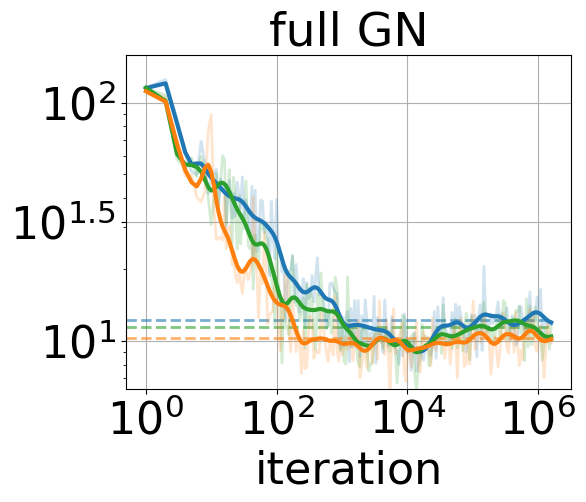

In [3]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(7, 5)) # was (8, 6)
fig.tight_layout()
lrs_id=[1, 2, 3]
cmap = [plt.cm.tab10(0), plt.cm.tab10(2), plt.cm.tab10(1)]
filter_sigma = .2

for i, lr_id in enumerate(lrs_id):
    iters = config_up[lr_id]['log_iters'][:len(trace_up[lr_id]['full_grad_norm'])]
    
    
    log_iters = torch.tensor(iters).to(torch.float64).log()
    F = -(log_iters.unsqueeze(0) - log_iters.unsqueeze(1)).square()
    F = (F / 2 / filter_sigma ** 2).exp()
    F /= F.sum(dim=1, keepdim=True)
    
    f = torch.tensor(trace_up[lr_id]['full_grad_norm'][:], dtype=torch.float64)
    ax.plot(iters[1:], (F @ f)[1:], color=cmap[i], zorder=10,
            label=f'{lrs_up[lr_id]:.1e}', linewidth=3)
        
ax.grid(True)
ax.set_yscale('log')    
ax.set_xscale('log')
ax.set_xticks(10 ** np.array([0, 2, 4, 6]))
x1, x2 = ax.get_xlim()
    
for i, lr_id in enumerate(lrs_id):
    iters = config_up[lr_id]['log_iters'][:len(trace_up[lr_id]['full_grad_norm'])]
    f = torch.tensor(trace_up[lr_id]['full_grad_norm'][:], dtype=torch.float64)
    ax.plot(iters[1:], f[1:], color=cmap[i], linewidth=2, alpha=.2)
    m = f[-50:].mean()
    ax.plot(np.logspace(np.log10(x1), np.log10(iters[-1]), 500), [m] * 500, '--', 
            lw=2., alpha=.6, color=cmap[i])


ax.set_title('full GN', fontsize=34)
ax.set_xlabel('iteration')
ax.set_xlim((x1, x2))

yticks = np.array([1.0, 1.5, 2.])
ax.set_yticks(10. ** yticks)
ax.set_ylim((10. ** .8, 10. ** 2.2))
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: (rf'$10^{{{np.log10(y):.1f}}}$') if np.log10(y) == 1.5 else rf'$10^{{{int(np.log10(y))}}}$')
)

fig.savefig(f'{plot_folder}up_full_grad_iter_conv.png', dpi=200, bbox_inches='tight')

#### UP stoch GN iter

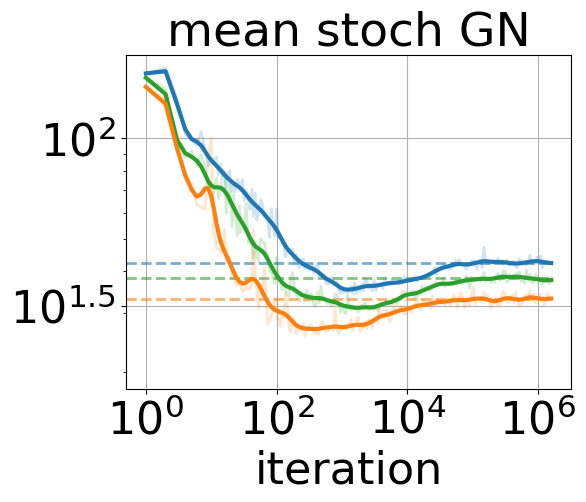

In [4]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout()

lrs_id=[1, 2, 3]
cmap = [plt.cm.tab10(0), plt.cm.tab10(2), plt.cm.tab10(1)]
filter_sigma = .2

for i, lr_id in enumerate(lrs_id):
    iters = config_up[lr_id]['log_iters'][:len(trace_up[lr_id]['stoch_grad_mean_norm'])]
    
    
    log_iters = torch.tensor(iters).to(torch.float64).log()
    F = -(log_iters.unsqueeze(0) - log_iters.unsqueeze(1)).square()
    F = (F / 2 / filter_sigma ** 2).exp()
    F /= F.sum(dim=1, keepdim=True)
    
    f = torch.tensor(trace_up[lr_id]['stoch_grad_mean_norm'][:], dtype=torch.float64)
    ax.plot(iters[1:], (F @ f)[1:], color=cmap[i], zorder=10,
            label=f'{lrs_up[lr_id]:.1e}', linewidth=3)
        
ax.grid(True)
ax.set_yscale('log')    
ax.set_xscale('log')
ax.set_xticks(10 ** np.array([0, 2, 4, 6]))
x1, x2 = ax.get_xlim()
    
for i, lr_id in enumerate(lrs_id):
    iters = config_up[lr_id]['log_iters'][:len(trace_up[lr_id]['stoch_grad_mean_norm'])]
    f = torch.tensor(trace_up[lr_id]['stoch_grad_mean_norm'][:], dtype=torch.float64)
    ax.plot(iters[1:], f[1:], color=cmap[i], linewidth=2, alpha=.2)
    m = f[-50:].mean()
    ax.plot(np.logspace(np.log10(x1), np.log10(iters[-1]), 500), [m] * 500, '--', 
            lw=2., alpha=.6, color=cmap[i])


ax.set_title('mean stoch GN', fontsize=34)
ax.set_xlabel('iteration')
ax.set_xlim((x1, x2))

yticks = np.array([1.5, 2.])
ax.set_yticks(10. ** yticks)
ax.set_ylim((10. ** 1.25, 10. ** 2.25))
ax.tick_params(axis='y', which='minor', labelleft=False)
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: (rf'$10^{{{np.log10(y):.1f}}}$') if np.log10(y) != 2. else rf'$10^{{{int(np.log10(y))}}}$')
)

fig.savefig(f'{plot_folder}up_stoch_grad_iter_conv.png', dpi=200, bbox_inches='tight')

#### UP SNR iter

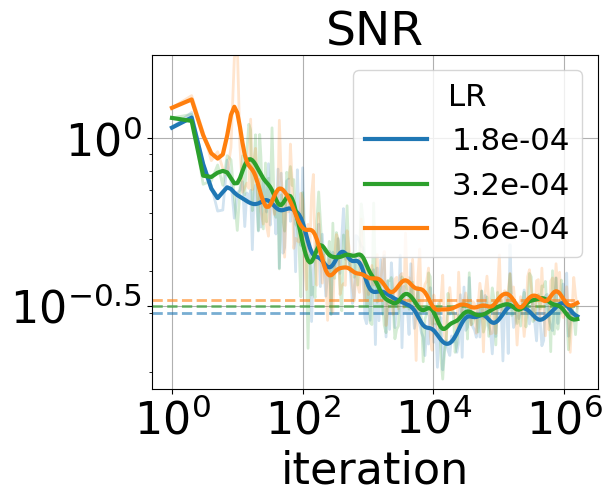

In [5]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout()
lrs_id = [1, 2, 3]
cmap = [plt.cm.tab10(0), plt.cm.tab10(2), plt.cm.tab10(1)]
filter_sigma = .2

for i, lr_id in enumerate(lrs_id):
    iters = config_up[lr_id]['log_iters'][:len(trace_up[lr_id]['snr_new'])]
    
    
    log_iters = torch.tensor(iters).to(torch.float64).log()
    F = -(log_iters.unsqueeze(0) - log_iters.unsqueeze(1)).square()
    F = (F / 2 / filter_sigma ** 2).exp()
    F /= F.sum(dim=1, keepdim=True)
    
    f = torch.tensor(trace_up[lr_id]['snr_new'][:], dtype=torch.float64)
    ax.plot(iters[1:], (F @ f)[1:], color=cmap[i], zorder=10,
            label=f'{lrs_up[lr_id]:.1e}', linewidth=3)
        
ax.grid(True)
ax.set_yscale('log')    
ax.set_xscale('log')
ax.set_xticks(10 ** np.array([0, 2, 4, 6]))
x1, x2 = ax.get_xlim()
    
for i, lr_id in enumerate(lrs_id):
    iters = config_up[lr_id]['log_iters'][:len(trace_up[lr_id]['snr_new'])]
    f = torch.tensor(trace_up[lr_id]['snr_new'][:], dtype=torch.float64)
    ax.plot(iters[1:], f[1:], color=cmap[i], linewidth=2, alpha=.2)
    m = f[-50:].mean()
    ax.plot(np.logspace(np.log10(x1), np.log10(iters[-1]), 500), [m] * 500, '--', 
            lw=2., alpha=.6, color=cmap[i])


ax.set_title('SNR', fontsize=34)
ax.set_xlabel('iteration')
ax.set_xlim((x1, x2))
ax.set_ylim((.2, 1.6))
yticks = np.array([-.5, 0.0])
ax.set_yticks(10. ** yticks)
ax.set_ylim((10. ** -.75, 10. ** .25))
ax.tick_params(axis='y', which='minor', labelleft=False)
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: (rf'$10^{{{np.log10(y):.1f}}}$') if np.log10(y) != 0.0 else rf'$10^{{{int(np.log10(y))}}}$')
)
plt.legend(loc='upper right', fontsize='x-small', title='LR', title_fontsize='x-small')
fig.savefig(f'{plot_folder}up_snr_iter_conv.png', dpi=200, bbox_inches='tight')

### OP full GN iter

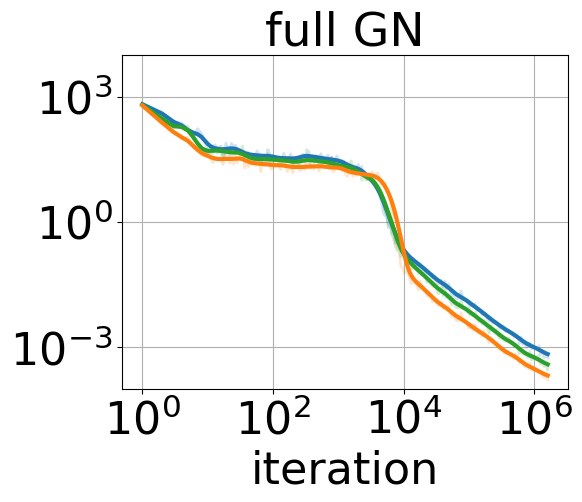

In [6]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout()
lrs_id = [1, 2, 3]
cmap = [plt.cm.tab10(0), plt.cm.tab10(2), plt.cm.tab10(1)]
filter_sigma = .2

for i, lr_id in enumerate(lrs_id):
    iters = config_op[lr_id]['log_iters'][:len(trace_op[lr_id]['full_grad_norm'])]
    
    
    log_iters = torch.tensor(iters).to(torch.float64).log()
    F = -(log_iters.unsqueeze(0) - log_iters.unsqueeze(1)).square()
    F = (F / 2 / filter_sigma ** 2).exp()
    F /= F.sum(dim=1, keepdim=True)
    
    f = torch.tensor(trace_op[lr_id]['full_grad_norm'][:], dtype=torch.float64)
    ax.plot(iters[1:], (F @ f)[1:], color=cmap[i], zorder=10,
            label=f'{lrs_op[lr_id]:.1e}', linewidth=3)
        
ax.grid(True)
ax.set_yscale('log')    
ax.set_xscale('log')
ax.set_xticks(10 ** np.array([0, 2, 4, 6]))
x1, x2 = ax.get_xlim()
    
for i, lr_id in enumerate(lrs_id):
    iters = config_op[lr_id]['log_iters'][:len(trace_op[lr_id]['full_grad_norm'])]
    f = torch.tensor(trace_op[lr_id]['full_grad_norm'][:], dtype=torch.float64)
    ax.plot(iters[1:], f[1:], color=cmap[i], linewidth=2, alpha=.2)


ax.set_title('full GN', fontsize=34)
ax.set_xlabel('iteration')
ax.set_xlim((x1, x2))
yticks = np.array([-3, 0, 3])
ax.set_yticks(10. ** yticks)
ax.set_ylim((10. ** -4, 10. ** 4))
ax.tick_params(axis='y', which='minor', labelleft=False)

fig.savefig(f'{plot_folder}op_full_grad_iter_conv.png', dpi=200, bbox_inches='tight')

### OP stoch GN iter

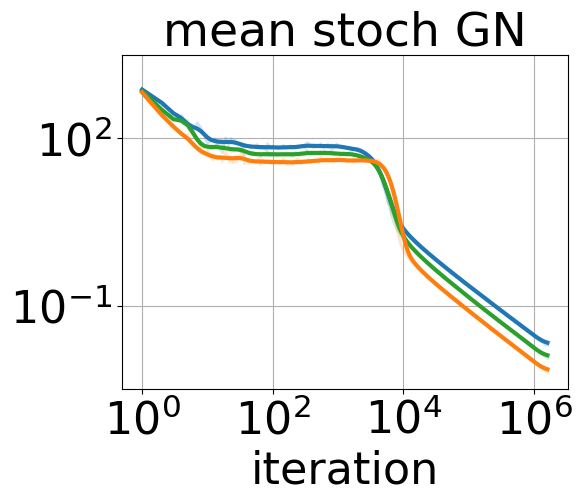

In [7]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout()
lrs_id = [1, 2, 3]
cmap = [plt.cm.tab10(0), plt.cm.tab10(2), plt.cm.tab10(1)]
filter_sigma = .2

for i, lr_id in enumerate(lrs_id):
    iters = config_op[lr_id]['log_iters'][:len(trace_op[lr_id]['stoch_grad_mean_norm'])]
    
    
    log_iters = torch.tensor(iters).to(torch.float64).log()
    F = -(log_iters.unsqueeze(0) - log_iters.unsqueeze(1)).square()
    F = (F / 2 / filter_sigma ** 2).exp()
    F /= F.sum(dim=1, keepdim=True)
    
    f = torch.tensor(trace_op[lr_id]['stoch_grad_mean_norm'][:], dtype=torch.float64)
    ax.plot(iters[1:], (F @ f)[1:], color=cmap[i], zorder=10,
            label=f'{lrs_op[lr_id]:.1e}', linewidth=3)
        
ax.grid(True)
ax.set_yscale('log')    
ax.set_xscale('log')
ax.set_xticks(10 ** np.array([0, 2, 4, 6]))
x1, x2 = ax.get_xlim()
    
for i, lr_id in enumerate(lrs_id):
    iters = config_op[lr_id]['log_iters'][:len(trace_op[lr_id]['stoch_grad_mean_norm'])]
    f = torch.tensor(trace_op[lr_id]['stoch_grad_mean_norm'][:], dtype=torch.float64)
    ax.plot(iters[1:], f[1:], color=cmap[i], linewidth=2, alpha=.2)


ax.set_title('mean stoch GN', fontsize=34)
ax.set_xlabel('iteration')
ax.set_xlim((x1, x2))
yticks = np.array([-1, 2])
ax.set_yticks(10. ** yticks)
ax.set_ylim((10. ** -2.5, 10. ** 3.5))
ax.tick_params(axis='y', which='minor', labelleft=False)

fig.savefig(f'{plot_folder}op_stoch_grad_iter_conv.png', dpi=200, bbox_inches='tight')

### OP SNR iter

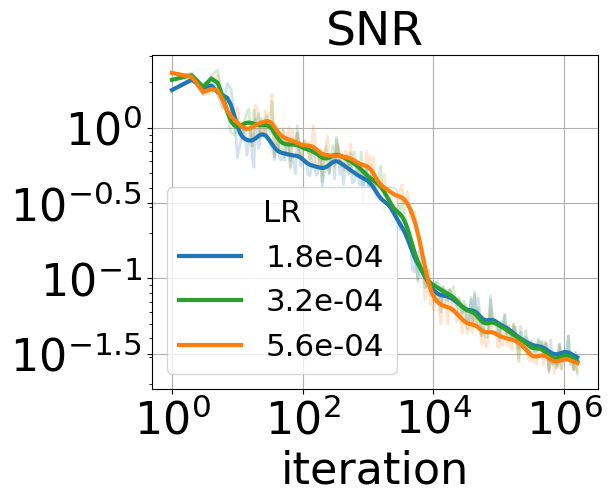

In [8]:
from matplotlib.ticker import FuncFormatter, FixedLocator

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout()
lrs_id = [1, 2, 3]
cmap = [plt.cm.tab10(0), plt.cm.tab10(2), plt.cm.tab10(1)]
filter_sigma = .2

for i, lr_id in enumerate(lrs_id):
    iters = config_op[lr_id]['log_iters'][:len(trace_op[lr_id]['snr_new'])]
    
    
    log_iters = torch.tensor(iters).to(torch.float64).log()
    F = -(log_iters.unsqueeze(0) - log_iters.unsqueeze(1)).square()
    F = (F / 2 / filter_sigma ** 2).exp()
    F /= F.sum(dim=1, keepdim=True)
    
    f = torch.tensor(trace_op[lr_id]['snr_new'][:], dtype=torch.float64)
    ax.plot(iters[1:], (F @ f)[1:], color=cmap[i], zorder=10,
            label=f'{lrs_op[lr_id]:.1e}', linewidth=3)
        
ax.grid(True)
ax.set_yscale('log')    
ax.set_xscale('log')
ax.set_xticks(10 ** np.array([0, 2, 4, 6]))
x1, x2 = ax.get_xlim()
    
for i, lr_id in enumerate(lrs_id):
    iters = config_op[lr_id]['log_iters'][:len(trace_op[lr_id]['snr_new'])]
    f = torch.tensor(trace_op[lr_id]['snr_new'][:], dtype=torch.float64)
    ax.plot(iters[1:], f[1:], color=cmap[i], linewidth=2, alpha=.2)


ax.set_title('SNR', fontsize=34)
ax.set_xlabel('iteration')
ax.set_xlim((x1, x2))
yticks = np.array([-1.5, -1.0, -.5, 0.0])
ax.set_yticks(10. ** yticks)
ax.tick_params(axis='y', which='minor', labelleft=False)
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: (rf'$10^{{{np.log10(y):.1f}}}$') if np.log10(y) != 0.0 and np.log10(y) != -1.0 else rf'$10^{{{int(np.log10(y))}}}$')
)
plt.legend(loc='lower left', fontsize='x-small', title='LR', title_fontsize='x-small')
fig.savefig(f'{plot_folder}op_snr_iter_conv.png', dpi=200, bbox_inches='tight')